In [ ]:
from tensorflow.keras.preprocessing import text
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
from common import transform_label_2
data = pd.read_excel("data/Data_Science_Jobs.xlsx")
data = data[['job_id', 'job_title', 'skill_name']]
data["job_title_trans"] = data["job_title"].apply(transform_label_2)
data = data[~data.job_title_trans.isnull()].reset_index()
len(data)

/var/folders/p4/824j72wj45j6vl163c2r94940000gn/T/ipykernel_4914/3459431671.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["job_title_trans"] = data["job_title"].apply(transform_label_2)


38999

In [4]:
data["job_title_color"] = data["job_title_trans"].apply(lambda x:
                                                        "tab:blue" if "engineer" == x else "tab:orange")

Model

In [5]:
def get_skill_name_trans(skill_names):
    return ",".join([item.strip() for item in skill_names.split(",")])

data["skill_name_trans"] = data.skill_name.apply(get_skill_name_trans)

In [6]:
len({x.strip() for idx, row in data.skill_name.items() for x in row.split(",")})

3927

In [9]:
tokenizer = text.Tokenizer(num_words=1000, split=",", filters="")
tokenizer.fit_on_texts(data['skill_name_trans'].values)
bag_of_words = tokenizer.texts_to_matrix(data['skill_name_trans'].values)

### TSNE Visualization

In [25]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=5000, random_state=23)
new_values = tsne_model.fit_transform(bag_of_words)
np.save('model/bow_classification.npy', new_values)

[Text(0.5, 1.0, 'T-SNE projection')]

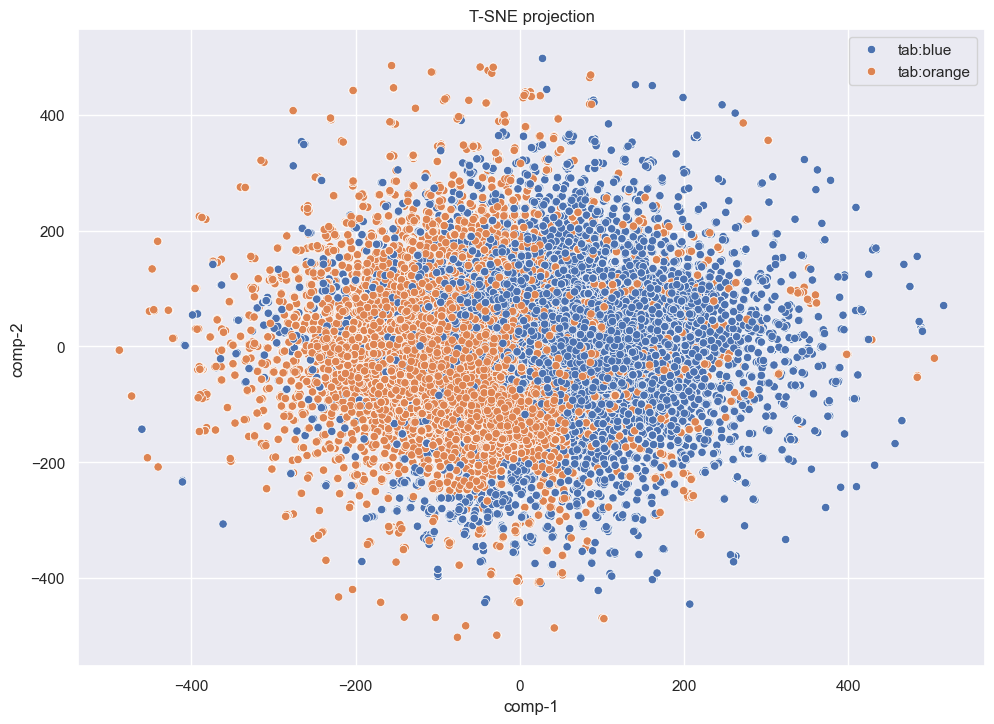

In [9]:
#text.Tokenizer(num_words=1000, split=",", filters="")
#TSNE(perplexity=40, n_components=2, init='pca', n_iter=5000, random_state=23)
new_values = np.load('model/bow_tsne_2D.npy')
df = pd.DataFrame()
df["y"] = data["job_title_color"]
df["comp-1"] = new_values[:,0]
df["comp-2"] = new_values[:,1]
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                data=df).set(title="T-SNE projection")

### Training Set

In [10]:
from sklearn.model_selection import train_test_split
from numpy import hstack,vstack

analysts = bag_of_words[data.job_title_trans == "analyst"]
engineers = bag_of_words[data.job_title_trans == "engineer"]

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(analysts, np.repeat("analyst", len(analysts)), train_size=5000, random_state=0)
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(engineers, np.repeat("engineer", len(engineers)), train_size=5000, random_state=0)

X_train = vstack((X_train_a, X_train_e))
y_train = hstack((y_train_a, y_train_e))

### Naive Bayes Classifier (Bernoulli)

In [11]:
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB().fit(X_train, y_train)

In [12]:
X_test, y_test = X_test_a, y_test_a # analysts

y_pred = bnb.predict(X_test)
print("Number of mislabeled analysts out of a total of %d : %d (Score: %f)" % (X_test.shape[0], (y_test != y_pred).sum(), bnb.score(X_test, y_test)))

Number of mislabeled analysts out of a total of 1654 : 296 (Score: 0.821040)


In [13]:
X_test, y_test = X_test_e, y_test_e # engineers

y_pred = bnb.predict(X_test)
print("Number of mislabeled engineers out of a total of %d : %d (Score: %f)" % (X_test.shape[0], (y_test != y_pred).sum(), bnb.score(X_test, y_test)))

Number of mislabeled engineers out of a total of 14835 : 1814 (Score: 0.877722)


In [15]:
from sklearn.inspection import permutation_importance

X_test = vstack((X_test_a, X_test_e))
y_test = hstack((y_test_a, y_test_e))

importances = permutation_importance(bnb, X_test, y_test)
importances_mean_sorted = np.argsort(importances.importances_mean)[::-1]
#for f in range(X_test.shape[1]):
for f in range(10):
    print("%d. %s (%f)" % (f + 1, tokenizer.index_word[importances_mean_sorted[f]],
                           importances.importances_mean[importances_mean_sorted[f]]))

1. central processing unit (cpu) (0.000752)
2. decision making (0.000679)
3. integration testing (i&t) (0.000619)
4. graphical user interface (gui) (0.000582)
5. computer engineering (ce) (0.000570)
6. data model (0.000558)
7. financial advice (0.000485)
8. app development (0.000485)
9. ms foundation class library (mfc) (0.000473)
10. warranty claims (0.000449)


### Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, max_iter=5000).fit(X_train, y_train)

In [16]:
X_test, y_test = X_test_a, y_test_a # analysts

y_pred_clf = clf.predict(X_test)
print("Number of mislabeled analysts out of a total of %d : %d (Score: %f)"
      % (X_test.shape[0], (y_test != y_pred_clf).sum(), clf.score(X_test, y_test)))

Number of mislabeled analysts out of a total of 1654 : 141 (Score: 0.914752)


In [17]:
X_test, y_test = X_test_e, y_test_e # engineers

y_pred_clf = clf.predict(X_test)
print("Number of mislabeled engineers out of a total of %d : %d (Score: %f)"
      % (X_test.shape[0], (y_test != y_pred_clf).sum(), clf.score(X_test, y_test)))

Number of mislabeled engineers out of a total of 14835 : 1397 (Score: 0.905831)


In [35]:
clf.classes_

array(['analyst', 'engineer'], dtype='<U8')

In [36]:
weights_sorted = [x.item() for x in np.argsort(clf.coef_.T, axis=0)[::-1]]
for f in range(0,10):
    print("%d. %s (%f)" % (f + 1, tokenizer.index_word[weights_sorted[f]],
                           clf.coef_.T[weights_sorted[f]]))

1. overall equipment effectiveness (oee) (2.872507)
2. morpholino (2.153371)
3. bottleneck (2.036349)
4. edge computing (1.970191)
5. automation engineering (1.822513)
6. manufacturing equipment maintenance (1.726899)
7. communications engineering (1.606963)
8. product engineering (1.593311)
9. wearable computer (1.581467)
10. document management system (dms) (1.507501)


In [37]:
for f in range(len(weights_sorted) - 10, len(weights_sorted)):
    print("%d. %s (%f)" % (f + 1, tokenizer.index_word[weights_sorted[f]],
                           clf.coef_.T[weights_sorted[f]]))

991. adobe analytics (-1.638103)
992. configuration management tool (-1.691464)
993. business development techniques (-1.792180)
994. database optimization (-1.835009)
995. general data protection regulation (gdpr) (-1.854468)
996. network protocol (-1.895275)
997. profit & loss (p&l) (-1.895770)
998. ibm - aix (-1.905551)
999. total cost of ownership (tco) (-2.065874)
1000. vue.js (-2.109119)


In [38]:
data["find_skill"] = data.skill_name_trans.apply(lambda x : True if "bottleneck" in x.lower() else False)
data[data.find_skill].skill_name_trans.iloc[0]

'Amazon Web Services (AWS),Behaviour Driven Development (BDD),Extract-Transform-Load (ETL) Technique,General Data Protection Regulation (GDPR),Apache Hadoop Distributed File System (HDFS),Internet of Things (IoT),Java - JUnit,Machine Learning,MongoDB,NoSQL Database,Object-Relational Mapping,RabbitMQ,XML SOAP,SQL,svn,Test-Driven Development (TDD),Agile Software Development,Ambition,Apache Oozie,Architecture & Construction Design,MS Azure,Bash Script (Unix),Big Data,Bottleneck,Business Requirement,Cloud Services,Configuration Management,Container,Data Management,Process and Data Modeling,Data Storage,Data Visualization,Data Warehouse,Database,Debugging,Software Design Pattern,Distributed Computing,Docker,Elasticsearch,Apache Flume,Apache Hadoop,Hands-On Mentality,Apache HBase,Apache Hive,Java,Kubernetes,Apache MapReduce,Apache Maven,Networking,Pentaho,Problem Solving,Programming Languages,Python,Redis,Resource Management,Scala,Software Development,Apache Solr,Spark,Stream Processing,Tabl